<a href="https://colab.research.google.com/github/Chorzy/EmotionAnalyzer/blob/main/Emotion_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Emotion Analyzer!

Vision Transformers using images found by sentiment search terms.

In [23]:
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

##Import libraries

In [24]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

## Defining the search terms

In [25]:
term_1 = "happy" #@param {type:"string"}
term_2 = "sad" #@param {type:"string"}
term_3 = "angry" #@param {type:"string"}
term_4 = "tired" #@param {type:"string"}

search_terms = sorted([
    term_1,
    term_2,
    term_3,
    term_4
])

search_terms = [x for x in search_terms if x.strip() != '']

## Gather Images from Fly API-Server

Filtering by search term and gathering 150 images for each term. Next, these are stored in the created folder `images/`.

In [26]:
SEARCH_URL = "https://huggingpics-api-server.fly.dev/images/search"

def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

In [27]:
data_dir = Path('images')

if data_dir.exists():
    shutil.rmtree(data_dir)

for search_term in search_terms:
    search_term_dir = data_dir / search_term
    search_term_dir.mkdir(exist_ok=True, parents=True)
    urls = get_image_urls_by_term(search_term)
    print(f"Saving images of {search_term} to {str(search_term_dir)}...")
    urls_to_image_folder(urls, search_term_dir)

Saving images of angry to images/angry...
Retrieved 95 images. Skipped 0.
Saving images of happy to images/happy...
Retrieved 150 images. Skipped 0.
Saving images of sad to images/sad...
Retrieved 150 images. Skipped 0.
Saving images of tired to images/tired...
Retrieved 150 images. Skipped 0.


## Initialize the Dataset and Split into Training and Validation Datasets (80/20 Split)


In [28]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .20)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Displaying some examples

This is to get a first glimpse of some of the images per search term. They seem to correlate in most cases so we can leave them as is. In some cases we may need to be more specific with the terms so the pulled images are more accurate.

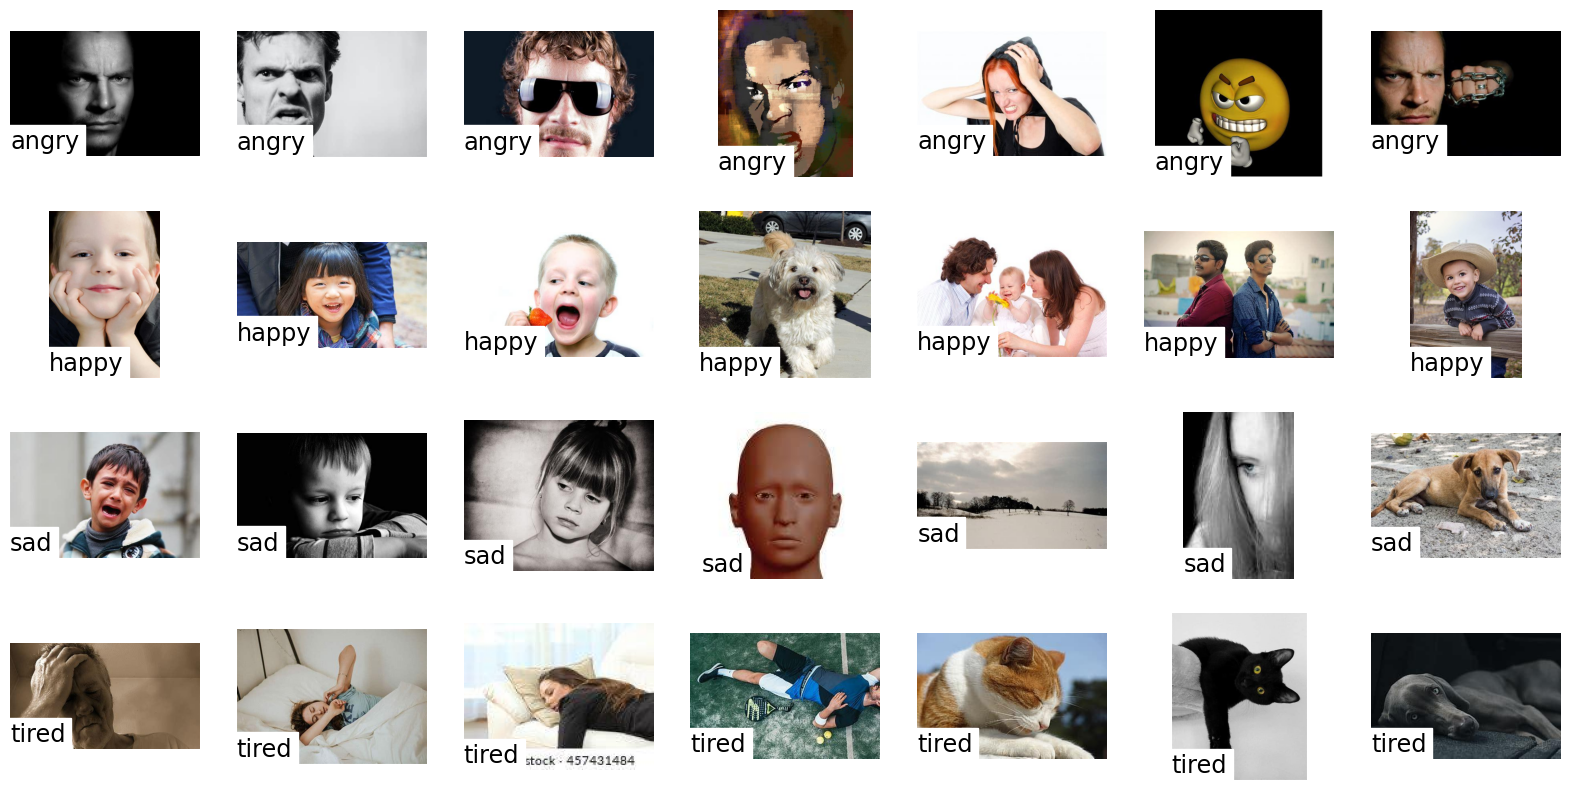

In [29]:
plt.figure(figsize=(20,10))
num_examples_per_class = 7
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Labeling model configuration


In [30]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [31]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

## Initialize Transformer Feature Extractor and Image Classifier


In [32]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=24, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=24, collate_fn=collator, num_workers=2)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training and Fine Tuning using Pytorch Lightning

In [33]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        # Initialize validation accuracy
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )
        # Initialize training accuracy
        self.train_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )
        # To store metrics for plotting
        self.train_losses = []
        self.train_accuracies = []  # List to store training accuracy for plotting
        self.val_losses = []
        self.val_accuracies = []


    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss
        preds = outputs.logits.argmax(dim=1)
        labels = batch['labels']
        acc = self.train_acc(preds, labels)
        self.train_losses.append(loss.item())
        self.train_accuracies.append(acc.item())  # Store training accuracy
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)  # Log training accuracy
        return loss


    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss.item()
        self.val_losses.append(loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.val_accuracies.append(acc.item())
        self.log(f"val_loss", loss)
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [34]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=8)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | ViTForImageClassification | 85.8 M
1 | val_acc   | MulticlassAccuracy        | 0     
2 | train_acc | MulticlassAccuracy        | 0     
--------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.207

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


## Plotting the test results


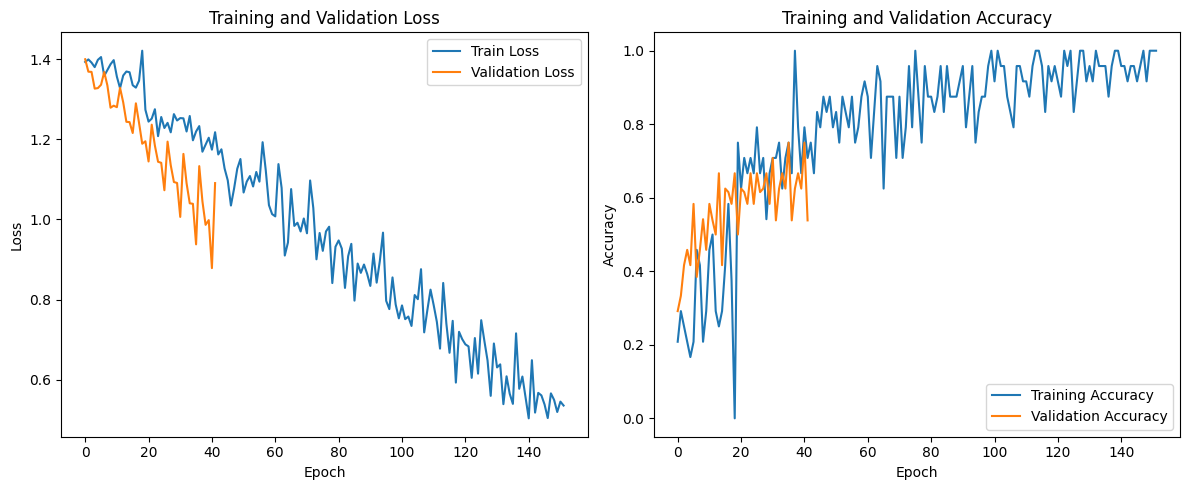

In [35]:
def plot_metrics(classifier):
    plt.figure(figsize=(12, 5))

    # Plot for Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(classifier.train_losses, label='Train Loss')
    plt.plot(classifier.val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(classifier.train_accuracies, label='Training Accuracy')  # Add training accuracy to the plot
    plt.plot(classifier.val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')  # Update title to reflect both metrics
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Assuming 'classifier' is an instance of your Classifier class after training
plot_metrics(classifier)


# Load the model into Huggingface

We will need to [sign up](https://huggingface.co/join) to Huggingface in order to run your model. Also, verification of Email adress is required.

The repository will be created at `{hf_username}/{model_id}`.

In [36]:
notebook_login()

In [38]:
model_id = "EmotionAnalyzer" #@param {type:"string"}

description = """
The Emotion Analyzer is ready!
"""
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

# Delete model folder, as we (re)create it here.
if Path('./model').exists():
    shutil.rmtree('./model')

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, repo_id=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from lightning_logs/ into ./model/runs/
tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    image_path = sorted(folder.glob('*'))[0]
    example_image_path = example_images_dir / f"{class_name.replace(' ', '_')}{image_path.suffix}"
    shutil.copy(image_path, example_image_path)
    example_images_markdown += image_markdown_template.format(
        class_name=class_name,
        example_image_path=example_image_path.name
    )


# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/Chorzy/EmotionAnalyzer into local empty directory.
Adding files tracked by Git LFS: ['images/angry.jpg', 'images/happy.jpg', 'images/sad.jpg', 'images/tired.jpg']. This may take a bit of time if the files are large.


Upload file model.safetensors:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file images/angry.jpg:   0%|          | 1.00/7.95k [00:00<?, ?B/s]

Upload file runs/events.out.tfevents.1717813760.0699c36ba4ef.261.4:   0%|          | 1.00/2.52k [00:00<?, ?B/s…

Upload file images/tired.jpg:   0%|          | 1.00/14.3k [00:00<?, ?B/s]

Upload file images/sad.jpg:   0%|          | 1.00/16.4k [00:00<?, ?B/s]

Upload file images/happy.jpg:   0%|          | 1.00/28.1k [00:00<?, ?B/s]

To https://huggingface.co/Chorzy/EmotionAnalyzer
   e795877..6367f8c  main -> main

   e795877..6367f8c  main -> main



Check out your model at:
https://huggingface.co/Chorzy/EmotionAnalyzer


# Evaluating the results


Predictions for human emotions

In [4]:
human_1 = 0.381 #@param {type:"number"}
human_2 = 0.402 #@param {type:"number"}
human_3 = 0.430 #@param {type:"number"}
human_4 = 0.527 #@param {type:"number"}
human_5 = 0.455 #@param {type:"number"}
human_6 = 0.380 #@param {type:"number"}
human_7 = 0.447 #@param {type:"number"}
human_8 = 0.335 #@param {type:"number"}
human_9 = 0.376 #@param {type:"number"}
human_10 = 0.388 #@param {type:"number"}
human_11 = 0.484 #@param {type:"number"}
human_12 = 0.445 #@param {type:"number"}
human_13 = 0.471 #@param {type:"number"}
human_14 = 0.375 #@param {type:"number"}
human_15 = 0.380 #@param {type:"number"}
human_16 = 0.323 #@param {type:"number"}
human_17 = 0.197 #@param {type:"number"}
human_18 = 0.505 #@param {type:"number"}
human_19 = 0.294 #@param {type:"number"}
human_20 = 0.299 #@param {type:"number"}

# Store the human scores in list
human_scores = [
    human_1, human_2, human_3, human_4, human_5, human_6, human_7, human_8, human_9,
    human_10, human_11, human_12, human_13, human_14, human_15, human_16, human_17,
    human_18, human_19, human_20
]

In [5]:
# Create human score list
human_scores = [score for score in human_scores if score != 0]

# Calculate the average
average_human = sum(human_scores) / len(human_scores)
print(f"Average Accuracy Score for humans: {average_human:.3f}")


Average Accuracy Score for humans: 0.395


Predictions for dog emotions

In [1]:
dog_1 = 0.165 #@param {type:"number"}
dog_2 = 0.282 #@param {type:"number"}
dog_3 = 0.274 #@param {type:"number"}
dog_4 = 0.221 #@param {type:"number"}
dog_5 = 0.219 #@param {type:"number"}
dog_6 = 0.186 #@param {type:"number"}
dog_7 = 0.269 #@param {type:"number"}
dog_8 = 0.302 #@param {type:"number"}
dog_9 = 0.241 #@param {type:"number"}
dog_10 = 0.226 #@param {type:"number"}
dog_11 = 0.262 #@param {type:"number"}
dog_12 = 0.151 #@param {type:"number"}
dog_13 = 0.167 #@param {type:"number"}
dog_14 = 0.172 #@param {type:"number"}
dog_15 = 0.237 #@param {type:"number"}
dog_16 = 0.269 #@param {type:"number"}
dog_17 = 0.246 #@param {type:"number"}
dog_18 = 0.170 #@param {type:"number"}
dog_19 = 0.225 #@param {type:"number"}
dog_20 = 0.252 #@param {type:"number"}

# Store the dog scores in list
dog_scores = [
    dog_1, dog_2, dog_3, dog_4, dog_5, dog_6, dog_7, dog_8, dog_9,
    dog_10, dog_11, dog_12, dog_13, dog_14, dog_15, dog_16, dog_17,
    dog_18, dog_19, dog_20
]

In [6]:
# Create dog score list
dog_scores = [score for score in dog_scores if score != 0]

# Calculate the average
average_dog = sum(dog_scores) / len(dog_scores)
print(f"Average Score for dogs: {average_dog:.3f}")


Average Score for dogs: 0.227
